In [399]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import re
import folium
import json
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Dataframe Preparation**

In [400]:
food = pd.read_pickle("food.pkl")
restaurants = pd.read_pickle("restaurants.pkl")

In [401]:
food.head(8)

Inspection ID                  DBA Name                  AKA Name  \
0        2320830       THE HOXTON, CHICAGO       THE HOXTON, CHICAGO   
1        2320795                       TBD              THE EXCHANGE   
2        2320719       4884 S ARCHER INC,.       4884 S ARCHER INC,.   
3        2320659        MCDONALDï¿½S 25088              MCDONALDï¿½S   
4        2320662          DOLLOP COFFEE CO          DOLLOP COFFEE CO   
5        2320674    FIVE IRON GOLF CHICAGO            FIVE IRON GOLF   
6        2320702    MAXWELL STREET EXPRESS    MAXWELL STREET EXPRESS   
7        2320682  EL PRESIDENTE RESTAURANT  EL PRESIDENTE RESTAURANT   

   License #  Facility Type             Risk Zip Inspection Date  \
0  2694640.0     Restaurant  Risk 2 (Medium)  07            2019   
1  2698572.0     Restaurant    Risk 1 (High)  54            2019   
2  2678088.0  Grocery Store     Risk 3 (Low)  32            2019   
3  2671720.0     Restaurant  Risk 2 (Medium)  01            2019   
4  2698381.0     Restaurant    Risk 1 (High)  13            2019   
5  2665181.0     Restaurant     Risk 3 (Low)  54            2019   
6  1647725.0     Restaurant  Risk 2 (Medium)  20            2019   
7    71168.0     Restaurant    Risk 1 (High)  14            2019   

           Inspection Type             Results  \
0                  License                Pass   
1                  License                Pass   
2                  License                Fail   
3    License Re-Inspection                Pass   
4                  License  Pass w/ Conditions   
5                  License                Pass   
6    Canvass Re-Inspection                Pass   
7  Complaint Re-Inspection  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0  36. THERMOMETERS PROVIDED & ACCURATE - Comment...  41.885699 -87.648789   
1                                                NaN  41.887529 -87.632647   
2                                                NaN  41.804621 -87.719907   
3                                                NaN  41.886567 -87.624385   
4  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...  41.961681 -87.670762   
5                                                NaN  41.892779 -87.629539   
6  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...  41.736080 -87.650859   
7  25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...  41.928682 -87.668415   

                     geometry        community area     shape_area area_num_1  \
0  POINT (-87.64879 41.88570)   NEAR WEST SIDE    0  158492466.554         28   
1  POINT (-87.63265 41.88753)  NEAR NORTH SIDE    0  76675895.9728          8   
2  POINT (-87.71991 41.80462)   ARCHER HEIGHTS    0  55922505.7212         57   
3  POINT (-87.62438 41.88657)             LOOP    0  46335565.4586         32   
4  POINT (-87.67076 41.96168)           UPTOWN    0  65095642.7289          3   
5  POINT (-87.62954 41.89278)  NEAR NORTH SIDE    0  76675895.9728          8   
6  POINT (-87.65086 41.73608)   AUBURN GRESHAM    0  105065353.602         71   
7  POINT (-87.66841 41.92868)     LINCOLN PARK    0  88316400.4728          7   

  area_numbe      shape_len  
0         28  53003.5929406  
1          8  57293.1649516  
2         57  31880.0210295  
3         32  39428.6729962  
4          3  46972.7945549  
5          8  57293.1649516  
6         71  46757.7217161  
7          7  49478.4277714

In [418]:
#verifying that we only have restaurant facilities
restaurants["Facility Type"].unique().tolist()

['Restaurant']

**Risk analysis:**

1) Percentage distribution of risk level throughout the years

2) Risk analysis per restaurant for 2018

3) Analysis based on a risk score

**1. Percentage distribution of risk level throughout the years** 

In [403]:
#risk distribution for every year
year_list = food["Inspection Date"].unique().tolist()
year_list.sort()
all_risks =  [[0 for _ in range(3)] for _ in range(len(year_list))]
year = 0
for i in year_list:
    all_risks[year] = food[food["Inspection Date"]==i].Risk.value_counts().sort_index().tail(3).tolist()
    year += 1

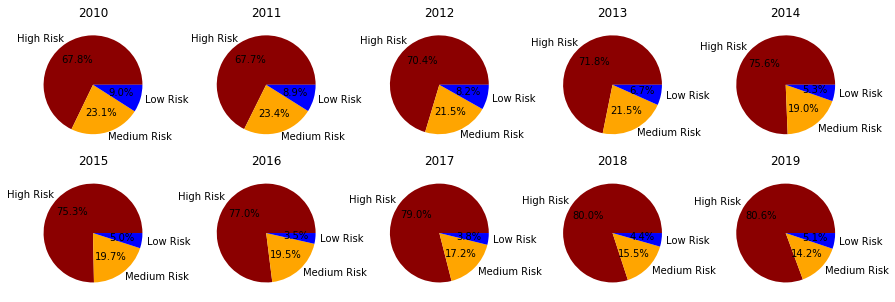

In [404]:
#plotting
labels = ['High Risk', 'Medium Risk', 'Low Risk']
fig, ax= plt.subplots(2,int(len(year_list)/2),figsize=(15,5))

year = 0
for i in range(2):
    for j in range(int(len(year_list)/2)):
        ax[i,j].pie(all_risks[year], labels = labels, autopct='%1.1f%%', colors=["darkred","orange","blue"])
        ax[i,j].set_title(year_list[year])
        year += 1

plt.show()

We can also represent it with a stacked percentage plot but before plotting, we need to normalize the data to be able to compare the evolution throughout the years

Text(0, 0.5, 'Percentage')

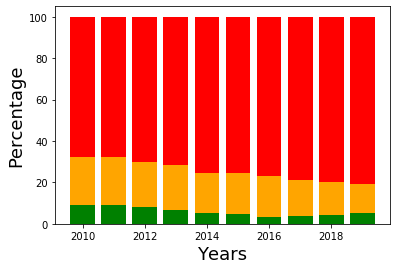

In [405]:
#x axis
years = [0]*len(year_list)
for i in range(0,len(year_list)):
    years[i]=2010+i

#y axis
scores1 = [100]*len(year_list)
scores2 = [0]*len(year_list)
scores3 = [0]*len(year_list)

#Plotting 
for j in range(0,len(year_list)):
    #scores1[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[0])/\
    #                (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores3[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[2])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores2[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[1])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())+scores3[j]

plt.bar(years, scores1, color='red')
plt.bar(years, scores2, color='orange')
plt.bar(years, scores3, color ='green')

plt.xlabel("Years", fontsize=18)
plt.ylabel("Percentage", fontsize=18)

We see that the distribution of different risk levels has slowly changed since 2010. There is a slow increase in high risk aka fast foods 

**2. Risk analysis per restaurant for 2018**

Here we are going to plot the different restaurants in the city in 2018 keeping only the highest risk grade given on a canvass inspection. This is because these inspections are directly related to inspection frequency which is linked to the risk.

In [406]:
#Creation of dataframe for 2018 restaurants and canvass inspection
new_restaurants = restaurants[restaurants["Inspection Date"]=='2018'].copy()
new_restaurants.reset_index(drop=True, inplace=True)
new_restaurants = new_restaurants[new_restaurants["Inspection Type"]=="Canvass"]
new_restaurants.sort_values(by = "Risk", inplace=True)
new_restaurants.drop_duplicates(subset="License #", inplace=True)
new_restaurants.reset_index(drop=True, inplace=True)

Here is the plotting mentioned before. The markers correspond to:blue for low risk, orange for medium risk and red for high risk. The layer represents the differents communities in the city that will be used later in our analysis. It should be displayed correctly on a FireFox browser but in case you are not able to see it, a html file is saved and can be opened on any browser to visualize it properly.

In [407]:
#Preview of risk values
new_restaurants.Risk.value_counts()

Risk 1 (High)      224
Risk 2 (Medium)    195
Risk 3 (Low)         1
Name: Risk, dtype: int64

In [408]:
#Function for plotting Chicago map with markers according to risk level
#Takes a dataframe and returns the map
def map_plot (df):
    #Creating the Chicago map
    chicago_coord = [41.85, -87.7]
    riskmap = folium.Map(location=chicago_coord)

    #Low risk
    for i in range(df[df.Risk.str.contains("3")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("3")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("3")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("3")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='blue', icon = 'map-marker')).add_to(riskmap)

    #Medium risk
    for i in range(df[df.Risk.str.contains("2")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("2")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("2")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("2")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='orange', icon = 'map-marker')).add_to(riskmap)

    #High risk
    for i in range(df[df.Risk.str.contains("1")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("1")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("1")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("1")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='red', icon = 'map-marker')).add_to(riskmap)
     
    geopath = r'Boundaries - Community Areas (current).geojson'
    geodata = json.load(open(geopath))
    folium.GeoJson(geodata).add_to(riskmap)
    
    return riskmap

In [409]:
#Plotting and saving
m = map_plot(new_restaurants.copy())
m.save("restaurants_risk_map.html")
m

We can see that we only have a single entry for low risk in the map above which means these chains are strictly rated. There is some kind of pattern that seems to appear in the distribution of medium risk and high risk restaurants. For example, more medium risk by the lake and more high risk by the suburbs. To have a better view of this analysis we are going to use the function below where we can choose which restaurant chain to display and later we will colorify the community layers according a risk score that we will define.

In [410]:
#Function to filter one of the 5 restaurants and return the map
def filter_map(df, restaurant):
    m = map_plot(new_restaurants[new_restaurants["AKA Name"]==restaurant].copy())
    m.save("risk_map_single_restaurant.html")
    return m

In [423]:
#list of restaurants to pick
list_restaurants = new_restaurants["AKA Name"].unique().tolist()
for i in list_restaurants:
    print(i)

SUBWAY
TACO BELL
MCDONALDS
STARBUCKS
DUNKIN DONUTS


In [424]:
#Example with Starbucks
filter_map(new_restaurants, "STARBUCKS")

In [425]:
#Example with Subway
filter_map(new_restaurants, "SUBWAY")

Playing with this plotting show us that some restaurants are simply fast foods with bad rating independently of location, i.e. Subway. Another problem is that the restaurants itself is not present in every community which means that we do not take on account high quality restaurants that will only be in certain locations. For a better study we will now take on account a much larger dataset using all dataset filtered by these facility types: restaurants(but all of them), grocery store, schools and hospitals.

**3. Analysis based on a risk score**

We are going to take back our cleaned dataset with the main facility types and use their risk value to define a risk score for each community. The score rule is as follows: 

$$\frac{(High + Medium*0.5)}{(High + Medium + Low)} $$

This formula is interesting because it give us an idea of the health risk we take when eating randomly in a community. For example, a community which only has low risk restaurant will have a score of 0 (the lowest possible risk) but a community with only high risk food will have the maximum score of 1.

In [414]:
#Creation of a dataframe for a complete analysis replacing risk text by its integer value
analysis_df = food.copy()
analysis_df.loc[analysis_df["Risk"].str.contains("1"), "Risk"] = '1'
analysis_df.loc[analysis_df["Risk"].str.contains("2"), "Risk"] = '2'
analysis_df.loc[analysis_df["Risk"].str.contains("3"), "Risk"] = '3'
analysis_df.Risk = analysis_df.Risk.astype(int)
analysis_df.sort_values(by=["community"], inplace=True)
analysis_df.reset_index(drop=True, inplace=True)
analysis_df.dropna(subset=["community"],inplace=True)

In [415]:
#Risk score calculation. Takes a dataframe and return a list with each community score
def risk_norm(df):    
    com_list = df.community.unique().tolist()
    risk_score=[0]*len(com_list)

    for i in range(len(com_list)):
        risk_count = [0]*3
        
        for j in range(len(df[df["community"]==com_list[i]].Risk.value_counts().tolist())):
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==1:
                risk_count[0] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[0]
                
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==2:
                risk_count[1] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[1]
                
            if df[df["community"]==com_list[i]].Risk.value_counts().index.tolist()[j]==3:
                risk_count[2] = df[df["community"]==com_list[i]].Risk.value_counts(sort=False, ascending=True).tolist()[2]
            
        risk_score[i]=(risk_count[0]+risk_count[1]*0.5)/sum(risk_count)
        
    return risk_score

Here is a resulting dataframe with the communities and their respecting scores. It will be very useful for plotting a Choropleth map giving a good visualization of the risk in each community

In [426]:
score_df = pd.DataFrame({'community' : analysis_df.community.unique().tolist(), 'Risk Score' : risk_norm(analysis_df)})
score_df.head(8)

community  Risk Score
0     ALBANY PARK    0.545585
1  ARCHER HEIGHTS    0.911097
2   ARMOUR SQUARE    0.540597
3         ASHBURN    0.768987
4  AUBURN GRESHAM    0.679544
5          AUSTIN    0.624964
6     AVALON PARK    0.761614
7        AVONDALE    0.865501